# Introduction
This project looks at manufacturing process data **(i.e. features)** and the yield **(i.e target)** of a drug , in hopes of finding a pattern or connection between the features and the target, i.e. building an accurate model. 

The following techniques will be used to build a model:
* **Data Cleaning** - dropped NAs and outliers after confirming it's ok to drop them, this was done in a separate [notebook](https://github.com/rosscleung/Projects/blob/master/Biologics/Biologics_Data_Wrangling.ipynb)
* **Feature Selection** - analyze scatter plots of features/targets, and use univariate feature selection techniques (SelectKBest)
* **Clustering** - get new features
* **Regression** - build a model to predict the target's value
* **Neural Network** - build a simple feedforward neural network
* **Classification**- build a model to predict the target's class
* **Cross Validiation** - determine legitimacy of model

# Study Summary
Regression and classification techniques were used to create models that try to make some sort of prediction with both  numerical and categorical targets. Feature scaling and engineering techniques were also used as part of data pre-processing, such as standard scaling, K-MEANs / DBSCAN clustering, and dummy variables creation for categorical features. Several regression and classification models were built with non-transformed data and PCA transformed data:


* Regression
    1. Linear Regression
    2. Decision Tree
    3. Random Forest
    4. Support Vector Regression
    5. Neural Network


* Classification
    1. K-Nearest-Neighbor
    2. Random Forest
    3. Logistic Regression
    4. Naive Bayes
    5. Neural Network
    
To advance this study further and chase accuaracy, I will need to get with my data team and get more samples, or identify other features that might have more impact to the yield. Accuracy improvement is an iterative and never ending process!

In [18]:
# Loading packages
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
sns.set_context('notebook')

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import feature_selection
from sklearn import metrics
from sklearn import grid_search
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import scipy.stats as spStats

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, RMSprop
from keras.models import save_model,load_model

import timeit
import pickle
from sklearn.externals import joblib
pd.set_option('display.max_columns',100)

# Data Summary
Unfortunately, I cannot explain the details about the data I used in this study, but basically there are 30+ features that I can choose from, and two target variables: One numerical target for regression, and one categorical for classification. Here is what the data looks like.

In [19]:
processed_df = pd.read_excel('processed_data.xlsx')
processed_df.head(1)

,Month,Year,Week No.,Date,Lot Number,Cut Lot Number,Bag/Bottle,PCA (%),PPT G (kg),CPP (kg),g PPT G/kg CPP,Total Protein (g/dL),CUNO Filt (kg),VP (L),Diluted CPP (kg),Dilution (kg),CPP IgG before Fr1,Cuno IgG FP6,Diluted % Efficiency,CPP (L),G Conv (g IgG/Kg PPT G),Yield CP (WT),Yield_Label,Yield_Label_2,Yield VP (WT),I - Final pH,I - Aging,II+III After Alc pH,II+III After Alc Titer,II+III - Final pH,II+III - Aging,II+III Paste Wt,Buffer 1 Amt,Extraction Ratio,Extract - Final pH,Extract - Aging,G - Init pH,G - titer,G - Final pH,G - Aging,TD_CT,FrI_PPT_CT,FrII_PPT_CT,V13_Sep_CT,Ext_PPT_CT,G_PPT_CT
0,1,2014,2,2014-01-06,LB1499004,LB149004,Bags,90.1,112.3,7479.7,15.013971,0.497,7839,7493.656,8241.938,762.238,500.0,466.5,0.909571,7297.268293,290.5,4.470598,acceptable,below mean,4.353436,7.22,7.505833,6.92,1.5,6.91,19.833333,701,6288.1,19.584228,5.07,3.326389,6.54,4.48,6.98,15.908333,8.6925,7.024167,14.136389,10.084722,-0.001111,39.180278


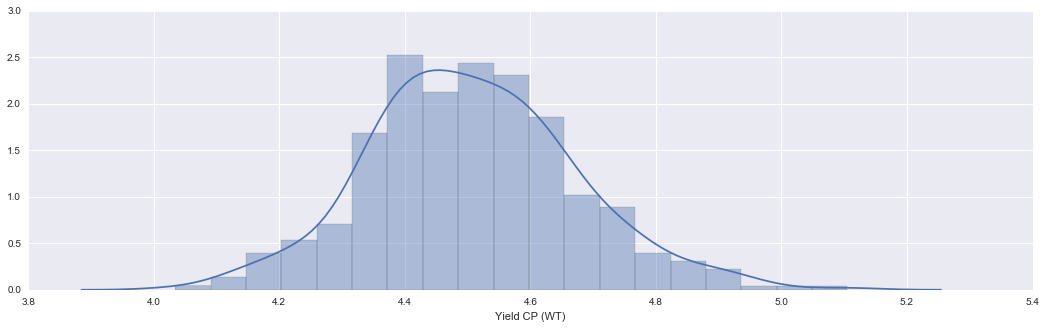

In [20]:
plt.figure(figsize=(18,5))
sns.distplot(processed_df['Yield CP (WT)'])

# Bag/Bottle Dummy Variables
There are 3 containers that the raw material is shipped in. I figure these can be used as categorical features.

In [21]:
Counter(processed_df['Bag/Bottle'])

Counter({u'Bags': 231, u'Bags/NMF': 38, u'Bottle': 131})

In [22]:
processed_df = pd.read_excel('processed_data.xlsx')
bag_bottle_dummies = pd.get_dummies(processed_df['Bag/Bottle'],prefix='bag_or_bottle_label')
processed_df = processed_df.join(bag_bottle_dummies)

# Features versus Target Plots
In features vs target plots, I'm looking for a linear trend. Even if there are groups, I can't use clustering algorithm to create new features because for any new data point, I won't have the target value to enter into a classification algorithm.

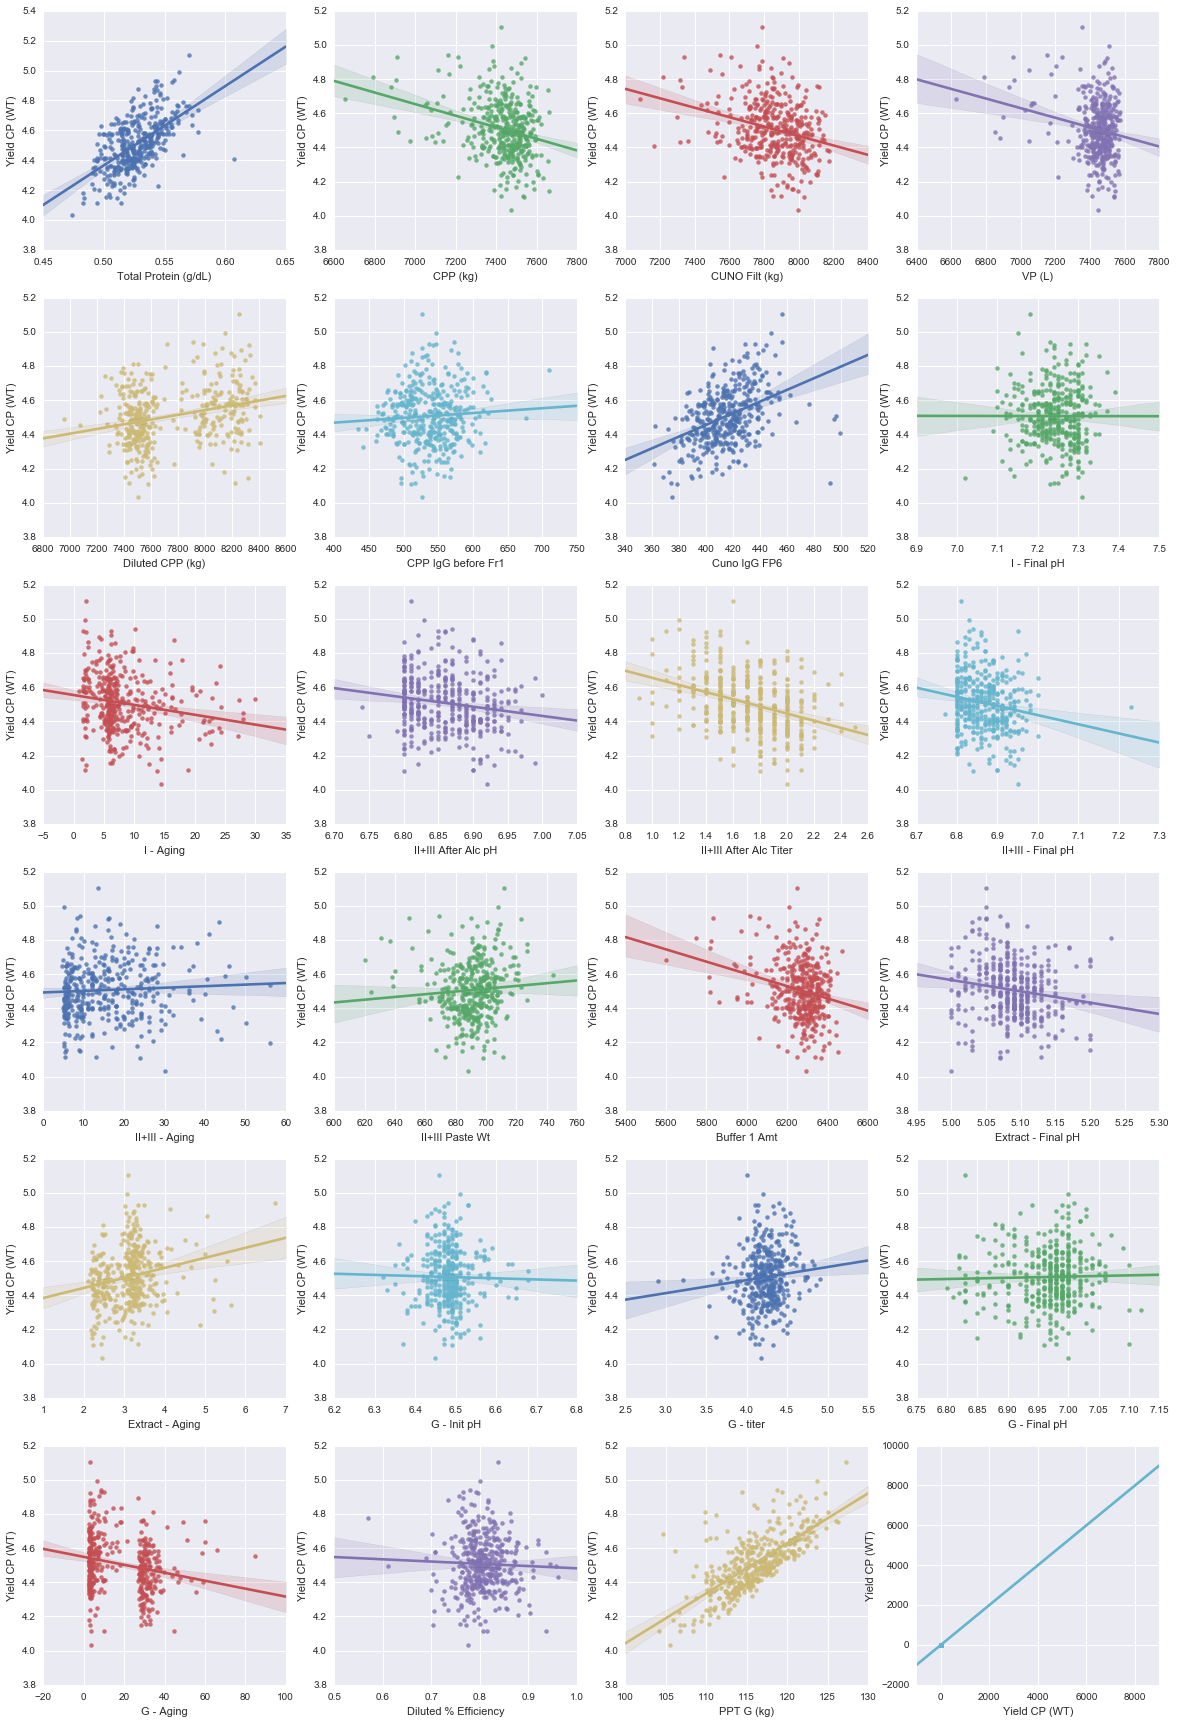

In [23]:
plotting_cols = [
#                 'Bag/Bottle',
                'Total Protein (g/dL)',
                'CPP (kg)',
                'CUNO Filt (kg)',
                'VP (L)',
                'Diluted CPP (kg)',
                'CPP IgG before Fr1',
                'Cuno IgG FP6',
                'I - Final pH',
                'I - Aging',
                'II+III After Alc pH',
                'II+III After Alc Titer',
                'II+III - Final pH',
                'II+III - Aging',
                'II+III Paste Wt',
                'Buffer 1 Amt',
                'Extract - Final pH',
                'Extract - Aging',
                'G - Init pH',
                'G - titer',
                'G - Final pH',
                'G - Aging',
                #'TD_CT',
                #'FrI_PPT_CT',
                #'FrII_PPT_CT',
                #'V13_Sep_CT',
                #'G_PPT_CT',
                'Diluted % Efficiency',
                'PPT G (kg)',
                'Yield CP (WT)'
               ]

target = 'Yield CP (WT)'
numOfRows = 6
numOfCols = 4
figure,axes = plt.subplots(nrows=numOfRows,ncols=numOfCols,figsize=(20,30),sharex=False)
x = 0
rValues_VS_Yield = {}
for r in range(numOfRows):
    for c in range(numOfCols):
        if x <len(plotting_cols):
            sns.regplot(data=processed_df,x=plotting_cols[x],y=target,ax=axes[r,c])
            rValues_VS_Yield[plotting_cols[x]] = spStats.pearsonr(processed_df[target],
                                                                  processed_df[plotting_cols[x]]) 
            x = x + 1
        else:
            pass

# Feature vs Feature Plots
In feature vs feature plots, I'm looking for groups so I can potentially use clustering algorithm to create new features. I am also looking for strong linear relationships so I won't feed in two highly correlated features into the model. 

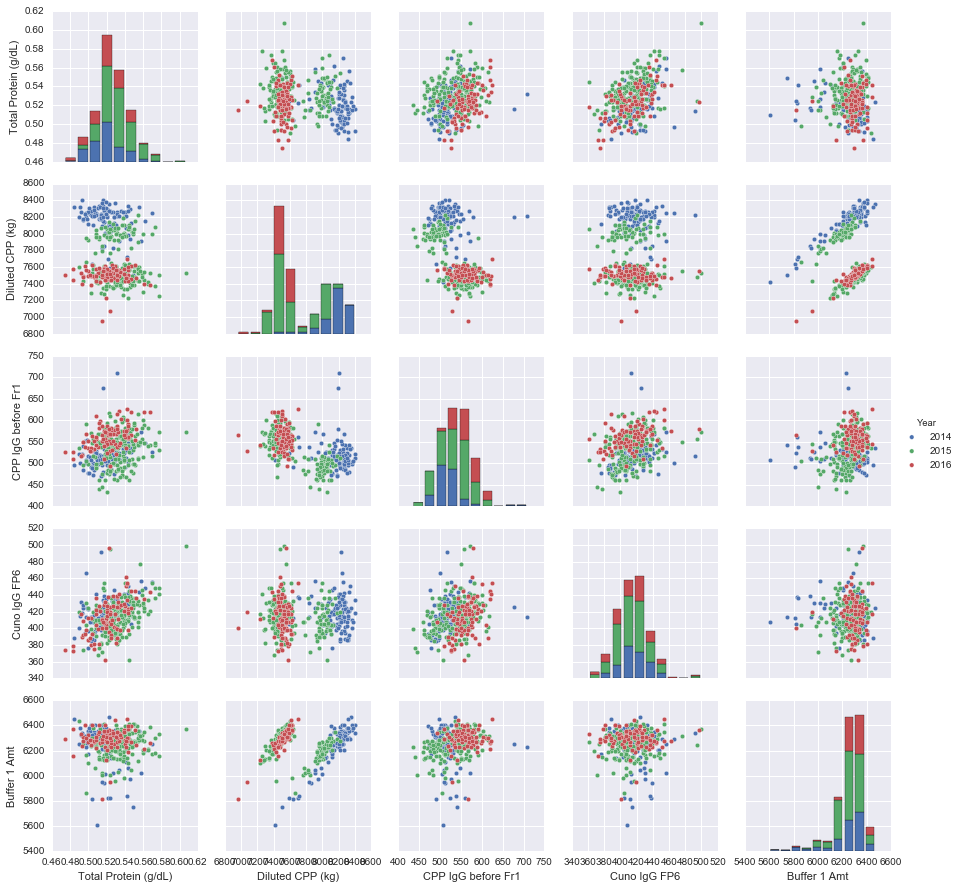

In [24]:
sns.pairplot(data=processed_df,
             vars=[
#                     'Bag/Bottle',
                    'Total Protein (g/dL)',
#                     'CPP (kg)',
#                     'CUNO Filt (kg)',
#                     'VP (L)',
                    'Diluted CPP (kg)',
                    'CPP IgG before Fr1',
                    'Cuno IgG FP6',
#                     'I - Final pH',
#                     'I - Aging',
#                     'II+III After Alc pH',
#                     'II+III After Alc Titer',
#                     'II+III - Final pH',
#                     'II+III - Aging',
#                     'II+III Paste Wt',
                    'Buffer 1 Amt',
#                     'Extract - Final pH',
#                     'Extract - Aging',
#                     'G - Init pH',
#                     'G - titer',
#                     'G - Final pH',
#                     'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'G_PPT_CT',
#                     'Diluted % Efficiency',
#                     'Yield CP (WT)'
                    ],
             hue='Year'
            )


# Using Clustering Algorithm to Get New Features

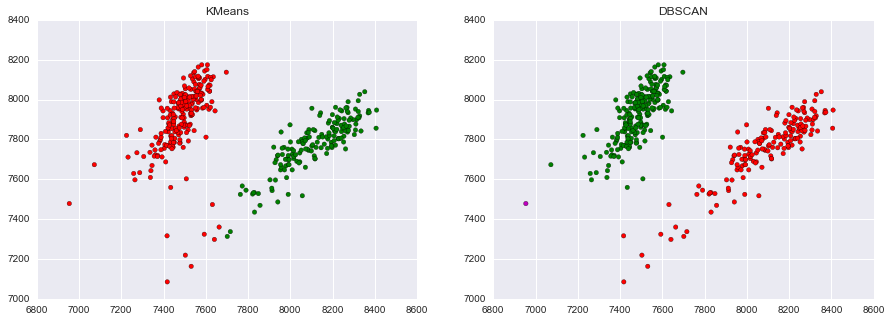

In [25]:
def get_colors(labels):
    pallete = 'rgbym'
    colors = []
    for i in labels:
        colors.append(pallete[i])
    return colors

first_feature = 'Diluted CPP (kg)'
second_feature = 'CUNO Filt (kg)'

f, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize=(15,5))

model = KMeans(n_clusters=2)
model.fit(processed_df[[first_feature,second_feature]])

axes[0].scatter(x=processed_df[first_feature],y=processed_df[second_feature], c=get_colors(model.labels_))
axes[0].set_title('KMeans')

model = DBSCAN(eps=170)
model.fit(processed_df[[first_feature,second_feature]])

axes[1].scatter(x=processed_df[first_feature],y=processed_df[second_feature], c=get_colors(model.labels_))
axes[1].set_title('DBSCAN')

After tweaking the parameters a bit, DBSCAN gave me the best clusters. Notice that in KMeans, several data points in the right cluster is labeled as the same as the one on the left. DBSCAN had much better separation with 1 outlier identified.

# Adding New Features from Clustering Algorithm

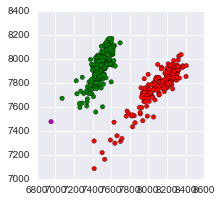

In [26]:
# Actually storing the labels. The cells above is my sandbox to look at the clustering results.
model = DBSCAN(eps=170)
model.fit(processed_df[['Diluted CPP (kg)','CUNO Filt (kg)']])

plt.figure(figsize=(3,3))
plt.scatter(x=processed_df['Diluted CPP (kg)'],y=processed_df['CUNO Filt (kg)'], c=get_colors(model.labels_))

processed_df['DilutedCPPvsCUNOFilt'] = model.labels_
dummies = pd.get_dummies(processed_df['DilutedCPPvsCUNOFilt'],prefix='DilutedCPPvsCUNOFilt')
processed_df = processed_df.join(dummies)

Adding a percentage feature, just to see if it will be of use later on.

In [27]:
processed_df['Buffer 1 Percentage'] = (processed_df['II+III Paste Wt']/processed_df['Buffer 1 Amt'])*100

# Converting the target numerical variable into a categorical variable
This is in preparation for classification models.

The add labels to the numerical target, I calculated the mean and standard deviation, and marked each value as either:
* More than 1 std below the mean
* Within 1 std below the mean
* Within than 1 std above the mean
* More than 1 std above the mean

In [28]:
# Calculating yield label column based on only 2015 and 2016 data
tempMean = np.mean(processed_df[processed_df['Year']!=2014]['Yield CP (WT)'])
tempStd = np.std(processed_df[processed_df['Year']!=2014]['Yield CP (WT)'])

tempList = []

for i in processed_df['Yield CP (WT)']:
    if i >= (tempMean+tempStd):
        tempList.append('above 1')
    elif i >= (tempMean):
        tempList.append('above mean')
    elif i >= (tempMean-tempStd):
        tempList.append('below mean')
    else:
        tempList.append('below 1')

processed_df['15and16_yield_label'] = tempList
processed_df[['Yield CP (WT)','15and16_yield_label']].head()

# Count of my new labels
print Counter(processed_df[processed_df['Year']!=2014]['15and16_yield_label'])
processed_df[processed_df['Year']!=2014][['Yield CP (WT)','15and16_yield_label']].head()

Counter({'below mean': 111, 'above mean': 91, 'above 1': 51, 'below 1': 39})


,Yield CP (WT),15and16_yield_label
108,4.565908,above mean
109,4.487960,above mean
110,4.225049,below 1
111,4.580379,above mean
112,4.525747,above mean


In [29]:
# Need to do some cleaning because of the new cluster features
processed_df2 = processed_df[processed_df['DilutedCPPvsCUNOFilt_-1']==0]
processed_df2.head()

,Month,Year,Week No.,Date,Lot Number,Cut Lot Number,Bag/Bottle,PCA (%),PPT G (kg),CPP (kg),g PPT G/kg CPP,Total Protein (g/dL),CUNO Filt (kg),VP (L),Diluted CPP (kg),Dilution (kg),CPP IgG before Fr1,Cuno IgG FP6,Diluted % Efficiency,CPP (L),G Conv (g IgG/Kg PPT G),Yield CP (WT),Yield_Label,Yield_Label_2,Yield VP (WT),I - Final pH,I - Aging,II+III After Alc pH,II+III After Alc Titer,II+III - Final pH,II+III - Aging,II+III Paste Wt,Buffer 1 Amt,Extraction Ratio,Extract - Final pH,Extract - Aging,G - Init pH,G - titer,G - Final pH,G - Aging,TD_CT,FrI_PPT_CT,FrII_PPT_CT,V13_Sep_CT,Ext_PPT_CT,G_PPT_CT,bag_or_bottle_label_Bags,bag_or_bottle_label_Bags/NMF,bag_or_bottle_label_Bottle,DilutedCPPvsCUNOFilt,DilutedCPPvsCUNOFilt_-1,DilutedCPPvsCUNOFilt_0,DilutedCPPvsCUNOFilt_1,Buffer 1 Percentage,15and16_yield_label
0,1,2014,2,2014-01-06,LB1499004,LB149004,Bags,90.1,112.3,7479.7,15.013971,0.497,7839,7493.656,8241.938,762.238,500.0,466.5,0.909571,7297.268293,290.5,4.470598,acceptable,below mean,4.353436,7.22,7.505833,6.92,1.5,6.91,19.833333,701,6288.10,19.584228,5.07,3.326389,6.54,4.48,6.98,15.908333,8.692500,7.024167,14.136389,10.084722,-0.001111,39.180278,1.0,0.0,0.0,0,0.0,1.0,0.0,11.148042,above mean
1,1,2014,2,2014-01-08,LB1499007,LB149007,Bags,91.1,111.3,7477.7,14.884256,0.509,7857,7487.663,8247.094,769.394,527.5,410.5,0.759924,7295.317073,290.5,4.431973,acceptable,below mean,4.318123,7.25,5.073333,6.88,1.7,6.91,6.066667,698,6306.90,19.648034,5.08,3.371111,6.41,4.77,6.83,8.701389,6.581667,12.799167,17.747778,7.583889,-0.001111,37.615833,1.0,0.0,0.0,0,0.0,1.0,0.0,11.067244,below mean
2,1,2014,2,2014-01-09,LB1499010,LB149010,Bags,89.6,110.0,7417.4,14.829994,0.497,7785,7433.027,8193.868,776.468,508.0,413.5,0.792694,7236.487805,290.5,4.415816,acceptable,below mean,4.299056,7.22,6.030556,6.92,1.7,6.91,5.883333,685,6225.88,19.553308,5.08,3.742222,6.57,4.20,6.90,10.620833,13.538889,6.866111,18.744444,7.042778,-0.001111,35.358056,1.0,0.0,0.0,0,0.0,1.0,0.0,11.002461,below mean
3,1,2014,2,2014-01-09,LB1499013,LB149013,Bags/NMF,90.8,114.3,7342.8,15.566269,0.523,7717,7471.656,8113.075,770.275,531.5,417.0,0.764926,7163.707317,290.5,4.635051,good,above mean,4.444015,7.24,11.579722,6.86,1.4,6.84,8.350000,678,6183.42,19.617255,5.05,3.217500,6.50,4.25,6.94,16.598889,5.982222,6.271667,12.984722,6.517500,-0.001111,39.269444,0.0,1.0,0.0,0,0.0,1.0,0.0,10.964806,above 1
4,1,2014,3,2014-01-10,LB1499016,LB149016,Bags,90.3,113.9,7398.1,15.395845,0.515,7882,7438.751,8179.693,781.593,473.5,405.5,0.845852,7217.658537,290.5,4.584305,good,above mean,4.448052,7.22,10.639444,6.83,1.5,6.84,7.000000,676,6238.54,19.644182,5.06,3.844167,6.49,4.40,6.99,17.464444,7.170000,8.272222,13.024444,6.097778,-0.001111,43.589167,1.0,0.0,0.0,0,0.0,1.0,0.0,10.835869,above mean


# Rescaling

In [30]:
rescaled_df = copy.deepcopy(processed_df2[processed_df2['Year']!=2014])
scaler = StandardScaler()

for i in rescaled_df.columns:
    if 'numpy' in str(type(rescaled_df[[i]].iloc[0][0])):
        if i != 'Yield CP (WT)' and \
           i != 'DilutedCPPvsCUNOFilt_-1' and \
           i != 'DilutedCPPvsCUNOFilt_0' and \
           i != 'DilutedCPPvsCUNOFilt_1' and \
           i != 'bag_or_bottle_label_Bags' and \
           i != 'bag_or_bottle_label_Bags/NMF' and \
           i != 'bag_or_bottle_label_Bottle':
            rescaled_df[i] = scaler.fit_transform(rescaled_df[[i]])
rescaled_df.describe()

,Month,Year,Week No.,PCA (%),PPT G (kg),CPP (kg),g PPT G/kg CPP,Total Protein (g/dL),CUNO Filt (kg),VP (L),Diluted CPP (kg),Dilution (kg),CPP IgG before Fr1,Cuno IgG FP6,Diluted % Efficiency,CPP (L),G Conv (g IgG/Kg PPT G),Yield CP (WT),Yield VP (WT),I - Final pH,I - Aging,II+III After Alc pH,II+III After Alc Titer,II+III - Final pH,II+III - Aging,II+III Paste Wt,Buffer 1 Amt,Extraction Ratio,Extract - Final pH,Extract - Aging,G - Init pH,G - titer,G - Final pH,G - Aging,TD_CT,FrI_PPT_CT,FrII_PPT_CT,V13_Sep_CT,Ext_PPT_CT,G_PPT_CT,bag_or_bottle_label_Bags,bag_or_bottle_label_Bags/NMF,bag_or_bottle_label_Bottle,DilutedCPPvsCUNOFilt,DilutedCPPvsCUNOFilt_-1,DilutedCPPvsCUNOFilt_0,DilutedCPPvsCUNOFilt_1,Buffer 1 Percentage
count,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,291.000000,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,2.910000e+02,291.000000,291.000000,291.000000,2.910000e+02,291.0,291.000000,291.000000,2.910000e+02
mean,3.197137e-16,1.791435e-13,2.138419e-16,-1.388938e-14,1.585788e-15,1.144941e-14,3.243492e-15,-2.198032e-16,2.360845e-15,-1.995874e-15,-2.074038e-15,1.535618e-16,-5.989863e-17,-8.813111e-16,1.486783e-15,7.271007e-15,-1.638802e-12,4.467894,1.310521e-16,9.263686e-15,-1.466944e-16,7.107716e-15,-1.012935e-16,-1.283586e-14,7.325183e-17,3.702269e-15,6.323121e-15,7.413505e-15,-5.003252e-15,3.872427e-16,-2.154434e-14,8.131144e-16,7.925695e-15,-1.568047e-16,1.308613e-16,3.641608e-16,-1.081609e-15,1.407809e-16,9.888997e-16,3.445125e-16,0.587629,0.099656,0.312715,7.790637e-16,0.0,0.223368,0.776632,-9.898916e-15
std,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,0.141333,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,1.001723e+00,0.493109,0.300057,0.464398,1.001723e+00,0.0,0.417220,0.417220,1.001723e+00
min,-1.261962e+00,-6.745369e-01,-1.342144e+00,-2.932684e+00,-2.825172e+00,-4.337050e+00,-3.035616e+00,-3.090993e+00,-4.401237e+00,-6.975820e+00,-2.307281e+00,-9.351922e-01,-2.946244e+00,-2.544194e+00,-2.845250e+00,-4.337050e+00,-5.872202e-02,4.034075,-3.006865e+00,-2.824449e+00,-1.151165e+00,-2.396935e+00,-2.575384e+00,-1.774691e+00,-1.111161e+00,-4.056307e+00,-4.589052e+00,-6.018896e+00,-2.488129e+00,-1.476895e+00,-3.484641e+00,-6.041006e+00,-2.951972e+00,-1.257165e+00,-1.320659e+00,-1.153888e+00,-1.016650e+00,-2.270960e+00,-1.079517e+00,-9.376327e-01,0.000000,0.000000,0.000000,-1.864651e+00,0.0,0.000000,0.000000,-3.494362e+00
25%,-6.544664e-01,-6.745369e-01,-8.010096e-01,-6.923679e-01,-7.058884e-01,-4.634986e-01,-6.437675e-01,-5.815972e-01,-6.771820e-01,-3.930896e-01,-6.372765e-01,-5.802262e-01,-6.589898e-01,-6.885019e-01,-5.949012e-01,-4.634986e-01,-5.872202e-02,4.376847,-6.972991e-01,-5.899732e-01,-6.583825e-01,-9.800583e-01,-8.515501e-01,-8.448473e-01,-8.054012e-01,-5.647552e-01,-4.624264e-01,-5.537060e-01,-4.677716e-01,-8.801465e-01,-3.529840e-01,-4.767538e-01,-5.258781e-01,-1.152731e+00,-7.241428e-01,-6.268149e-01,-6.777510e-01,-3.360177e-01,-1.079202e+00,-7.287197e-01,0.000000,0.000000,0.000000,5.362934e-01,0.0,0.000000,1.000000,-6.477634e-01
50%,-4.697127e-02,-6.745369e-01,-1.922330e-01,5.440400e-02,-5.178853e-02,1.378981e-01,-6.701292e-02,-2.395376e-02,3.304414e-02,1.169785e-01,-3.418992e-01,-4.673985e-01,1.213673e-01,-4.

In [31]:
rescaled_df.to_excel('rescaled_data.xlsx')

# SelectKBest Features
This helped me select a few features that I can start training the model with.

In [32]:
# Selecting K Best Features
feature_cols = [
#                     'Bag/Bottle',
#                     'PCA (%)',
#                     'PPT G (kg)',
#                     'CPP (kg)',
#                     'g PPT G/kg CPP',
                    'Total Protein (g/dL)',
                    'CUNO Filt (kg)',
                    'VP (L)',
                    'Diluted CPP (kg)',
#                     'Dilution (kg)',
                    'CPP IgG before Fr1',
#                     'Cuno IgG FP6',
                    'Diluted % Efficiency',
#                     'CPP (L)',
#                     'G Conv (g IgG/Kg PPT G)',
#                     'Yield CP (WT)',
#                     'Yield_Label',
#                     'Yield_Label_2',
#                     'Yield VP (WT)',
                    'I - Final pH',
                    'I - Aging',
                    'II+III After Alc pH',
                    'II+III After Alc Titer',
                    'II+III - Final pH',
                    'II+III - Aging',
                    'II+III Paste Wt',
                    'Buffer 1 Amt',
                    'Buffer 1 Percentage',
                    'Extraction Ratio',
                    'Extract - Final pH',
                    'Extract - Aging',
                    'G - Init pH',
                    'G - titer',
                    'G - Final pH',
                    'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'Ext_PPT_CT',
#                     'G_PPT_CT',
                    'bag_or_bottle_label_Bags',
                    'bag_or_bottle_label_Bags/NMF',
                    'bag_or_bottle_label_Bottle',
#                     'DilutedCPPvsCUNOFilt',
#                     'DilutedCPPvsCUNOFilt_-1',
                    'DilutedCPPvsCUNOFilt_0',
                    'DilutedCPPvsCUNOFilt_1'
                    ]

selector = feature_selection.SelectKBest(feature_selection.f_regression,k=5)
selector.fit_transform(rescaled_df[feature_cols],rescaled_df['Yield CP (WT)'])
tempList = selector.get_support(indices=True)
print rescaled_df[feature_cols].columns[tempList]

Index([        u'Total Protein (g/dL)',          u'Buffer 1 Percentage',
                   u'Extraction Ratio',     u'bag_or_bottle_label_Bags',
       u'bag_or_bottle_label_Bags/NMF'],
      dtype='object')


# Recursive Feature Elimination
This didn't work so well because RFE tries to maximize the coefficient of my algorithm, and my coefficients are highly affected by the scale of my features.

In [33]:
# Uses the feature_cols from Select K Best section above
model = LinearRegression(fit_intercept=False)
rfe = feature_selection.rfe.RFE(estimator=model,n_features_to_select=5)

rfe.fit(processed_df2[feature_cols],processed_df2['Yield CP (WT)'])
tempList = rfe.get_support()

for i in range(len(tempList)):
    if tempList[i]:
        print processed_df2[feature_cols].columns[i]

Total Protein (g/dL)
II+III After Alc pH
Extract - Final pH
DilutedCPPvsCUNOFilt_0
DilutedCPPvsCUNOFilt_1


# Helper Functions

In [34]:
def regression_charts(model, x_train, x_test, y_train, y_test,residuals):
    'This function creates charts that shows the regression model performance.'
    figure,axes = plt.subplots(nrows=2,ncols=2,figsize=(15,10),sharex=False)

    axes[0,0].plot(range(len(x_train)),model.predict(x_train),'r',label='prediction')
    axes[0,0].plot(range(len(y_train)),y_train,'b',label='truth')
    axes[0,0].set_title('Regressor Training')
    axes[0,0].legend()


    axes[1,0].plot(range(len(x_test)),pred,'r',label='prediction')
    axes[1,0].plot(range(len(y_test)),y_test,'b',label='truth')
    axes[1,0].set_title('Regressor Prediction')
    axes[1,0].legend()

    axes[0,1].plot(y_test,y_test,c='r')
    axes[0,1].scatter(x=pred,y=y_test)
    axes[0,1].set_xlabel('Predictions')
    axes[0,1].set_ylabel('y_test')
    axes[0,1].set_title('Prediction vs y_test')

    sns.distplot(residuals, ax=axes[1,1], kde= False, norm_hist=False)
    plt.title('Residuals')
    
    return None

In [35]:
def load_regression_data(randomState = 1):
    feature_cols = [
#                     'Bag/Bottle',
#                     'PCA (%)',
#                     'PPT G (kg)',
#                       'CPP (kg)',
#                     'g PPT G/kg CPP',
                      'Total Protein (g/dL)',
                      'CUNO Filt (kg)',
#                     'VP (L)',
#                     'Diluted CPP (kg)',
#                     'Dilution (kg)',
#                     'CPP IgG before Fr1',
#                     'Cuno IgG FP6',
#                     'Diluted % Efficiency',
#                     'CPP (L)',
#                     'G Conv (g IgG/Kg PPT G)',
#                     'Yield CP (WT)',
#                     'Yield_Label',
#                     'Yield_Label_2',
#                     'Yield VP (WT)',
#                     'I - Final pH',
#                     'I - Aging',
#                     'II+III After Alc pH',
                    'II+III After Alc Titer',
#                     'II+III - Final pH',
#                     'II+III - Aging',
#                     'II+III Paste Wt',
#                     'Buffer 1 Amt',
                    'Buffer 1 Percentage',
#                     'Extraction Ratio',
#                     'Extract - Final pH',
#                     'Extract - Aging',
#                     'G - Init pH',
#                     'G - titer',
#                     'G - Final pH',
#                     'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'Ext_PPT_CT',
# #                     'G_PPT_CT',
                    'bag_or_bottle_label_Bags',
                    'bag_or_bottle_label_Bags/NMF',
                    'bag_or_bottle_label_Bottle',
#                     'DilutedCPPvsCUNOFilt',
#                     'DilutedCPPvsCUNOFilt_-1',
                    'DilutedCPPvsCUNOFilt_0',
                    'DilutedCPPvsCUNOFilt_1'
                    ]

#     features = processed_df2[feature_cols]
#     target = processed_df2['Yield CP (WT)']
    features = rescaled_df[feature_cols]
    target = rescaled_df['Yield CP (WT)']


    return train_test_split(features,target,test_size=0.5, random_state=randomState)


In [36]:
def load_classification_data(randomState = 1):
    feature_cols = [
#                     'Bag/Bottle',
#                     'PCA (%)',
#                     'PPT G (kg)',
#                       'CPP (kg)',
#                     'g PPT G/kg CPP',
                      'Total Protein (g/dL)',
                      'CUNO Filt (kg)',
#                     'VP (L)',
#                     'Diluted CPP (kg)',
#                     'Dilution (kg)',
#                     'CPP IgG before Fr1',
#                     'Cuno IgG FP6',
#                     'Diluted % Efficiency',
#                     'CPP (L)',
#                     'G Conv (g IgG/Kg PPT G)',
#                     'Yield CP (WT)',
#                     'Yield_Label',
#                     'Yield_Label_2',
#                     'Yield VP (WT)',
#                     'I - Final pH',
#                     'I - Aging',
#                     'II+III After Alc pH',
                    'II+III After Alc Titer',
#                     'II+III - Final pH',
#                     'II+III - Aging',
#                     'II+III Paste Wt',
#                     'Buffer 1 Amt',
                    'Buffer 1 Percentage',
#                     'Extraction Ratio',
#                     'Extract - Final pH',
#                     'Extract - Aging',
#                     'G - Init pH',
#                     'G - titer',
#                     'G - Final pH',
#                     'G - Aging',
#                     'TD_CT',
#                     'FrI_PPT_CT',
#                     'FrII_PPT_CT',
#                     'V13_Sep_CT',
#                     'Ext_PPT_CT',
# #                     'G_PPT_CT',
                    'bag_or_bottle_label_Bags',
                    'bag_or_bottle_label_Bags/NMF',
                    'bag_or_bottle_label_Bottle',
#                     'DilutedCPPvsCUNOFilt',
#                     'DilutedCPPvsCUNOFilt_-1',
                    'DilutedCPPvsCUNOFilt_0',
                    'DilutedCPPvsCUNOFilt_1'
                    ]


    features = rescaled_df[feature_cols]
    target = rescaled_df['15and16_yield_label']

    return train_test_split(features,target,test_size=0.3, random_state=randomState)

# Regressions
With manually selected features.

## Linear Regression

Coefficients and p-value:
Total Protein (g/dL): 0.0910631258611, 7.28614211418e-25
CUNO Filt (kg): 0.016295268645, 0.52069510882
II+III After Alc Titer: -0.017891241727, 0.0303454046112
Buffer 1 Percentage: 0.0126432600976, 0.0650853726163
bag_or_bottle_label_Bags: -0.0213161792761, 2.09915515765e-05
bag_or_bottle_label_Bags/NMF: 0.0425923124035, 6.91654055233e-07
bag_or_bottle_label_Bottle: -0.0212761331274, 0.268512721077
DilutedCPPvsCUNOFilt_0: -0.0134978347655, 0.51601094478
DilutedCPPvsCUNOFilt_1: 0.0134978347655, 0.51601094478

Training R-Squared: 0.565400396889
Testing R-Squared: 0.549396853994
Mean Squared Error: 0.00918844911942
Mean Absolute Error: 0.0734420421157
Mean Absolute Error %: 1.63998332104


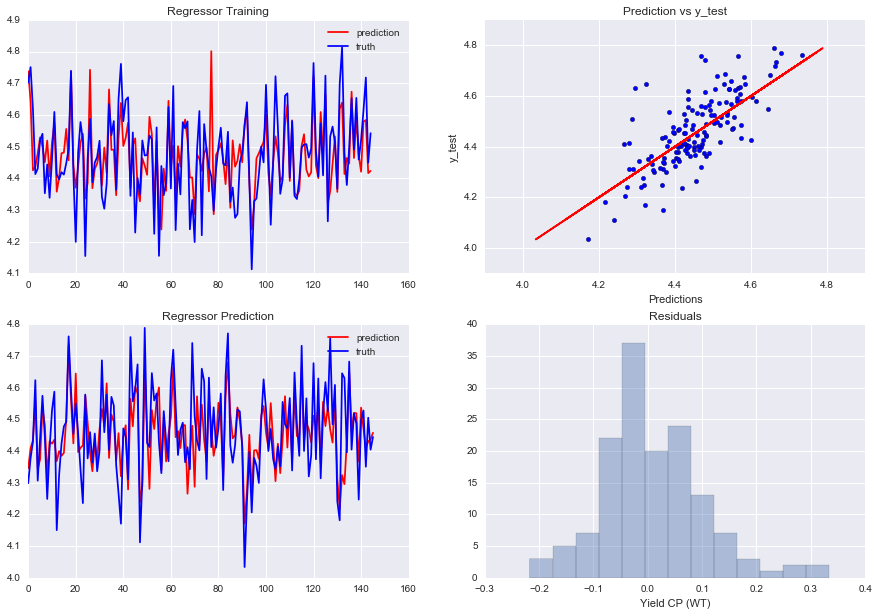

In [37]:
x_train, x_test, y_train, y_test = load_regression_data()

# Setting fit intercept to be true to improve coefficient interpretability
model = LinearRegression(fit_intercept=True)
model.fit(x_train,y_train)

pred = model.predict(x_test)
residuals = y_test - pred

regression_charts(model, x_train, x_test, y_train, y_test, residuals)

# P-Value might be different from the r_df table above because I might be slicing the data set differently 
# after selecting certain features.
x=0
print 'Coefficients and p-value:'
for i in model.coef_:
    print '{}: {}, {}'.format(x_train.columns[x],i,spStats.pearsonr(x_train[x_train.columns[x]], y_train.values)[1])
    x = x + 1
                              

print ''
print 'Training R-Squared:',model.score(x_train,y_train)
print 'Testing R-Squared:',model.score(x_test,y_test)


print 'Mean Squared Error:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,pred)
print 'Mean Absolute Error %:', sum(abs((y_test-pred) / y_test) / len(y_test))*100

In [38]:
model.coef_

array([ 0.09106313,  0.01629527, -0.01789124,  0.01264326, -0.02131618,
        0.04259231, -0.02127613, -0.01349783,  0.01349783])

In [39]:
x_train.describe()

,Total Protein (g/dL),CUNO Filt (kg),II+III After Alc Titer,Buffer 1 Percentage,bag_or_bottle_label_Bags,bag_or_bottle_label_Bags/NMF,bag_or_bottle_label_Bottle,DilutedCPPvsCUNOFilt_0,DilutedCPPvsCUNOFilt_1
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.116034,-0.024583,0.034144,-0.062759,0.558621,0.117241,0.324138,0.206897,0.793103
std,0.996354,1.019909,1.021829,1.040257,0.498273,0.322823,0.469674,0.406485,0.406485
min,-1.975706,-4.401237,-2.575384,-3.494362,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.525833,-0.646303,-0.851550,-0.722675,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.087575,-0.022539,0.010367,-0.114561,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.589454,0.755622,0.872283,0.427975,1.000000,0.000000,1.000000,0.000000,1.000000
max,4.325665,1.614069,3.027075,2.869032,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
#joblib.dump(model,'models/Linear_Regression/Linear_Regression_Model.pkl')
print ''

## Decision Tree Regressor

Mean Squared Error: 0.0115927149148
Mean Absolute Error: 0.0790440979772
Mean Absolute Error %: 1.76604912772


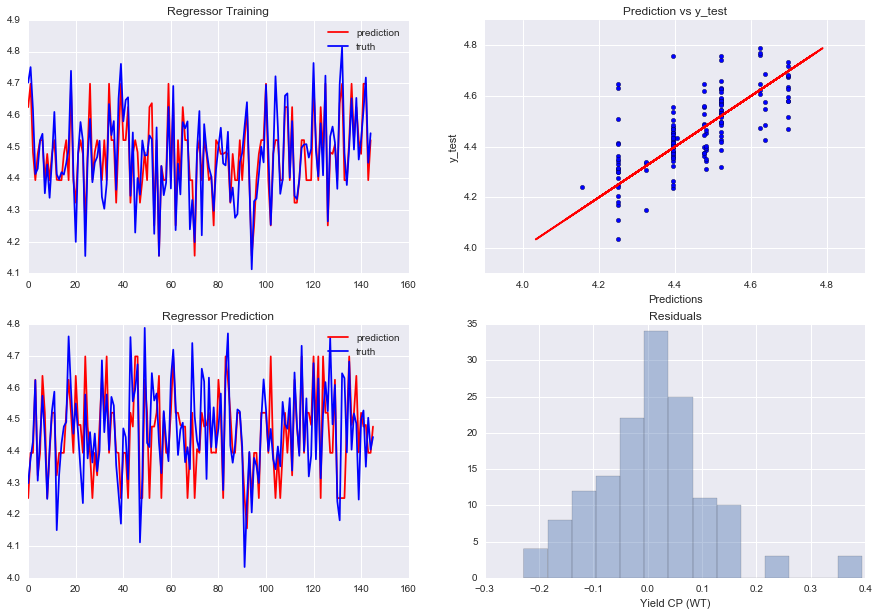

In [41]:
x_train, x_test, y_train, y_test = load_regression_data()

model = DecisionTreeRegressor(max_depth=4)
model.fit(x_train,y_train)

pred = model.predict(x_test)
residuals = y_test - pred

regression_charts(model, x_train, x_test, y_train, y_test, residuals)

print 'Mean Squared Error:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,pred)
print 'Mean Absolute Error %:', sum(abs((y_test-pred) / y_test) / len(y_test))*100

## Random Forest Regressor

Mean Squared Error: 0.010583581477
Mean Absolute Error: 0.0744965976497
Mean Absolute Error %: 1.6646026639


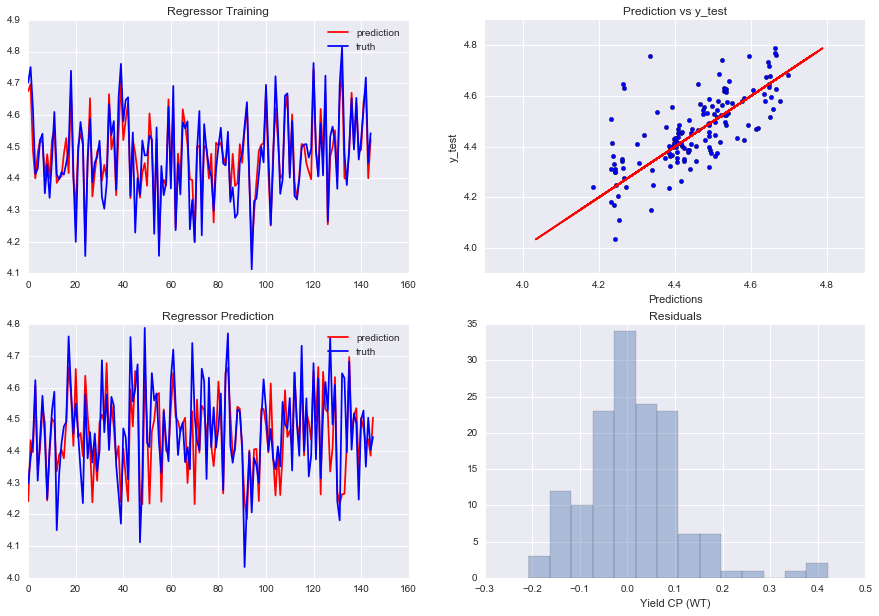

In [42]:
x_train, x_test, y_train, y_test = load_regression_data()

model = RandomForestRegressor(max_depth=5, n_estimators=30, random_state=1)
model.fit(x_train,y_train)

pred = model.predict(x_test)
residuals = y_test - pred

regression_charts(model, x_train, x_test, y_train, y_test, residuals)


print 'Mean Squared Error:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,pred)
print 'Mean Absolute Error %:', sum(abs((y_test-pred) / y_test) / len(y_test))*100

## Support Vector Regressor

Mean Squared Error: 0.0108570266704
Mean Absolute Error: 0.0797310517029
Mean Absolute Error %: 1.77591438488


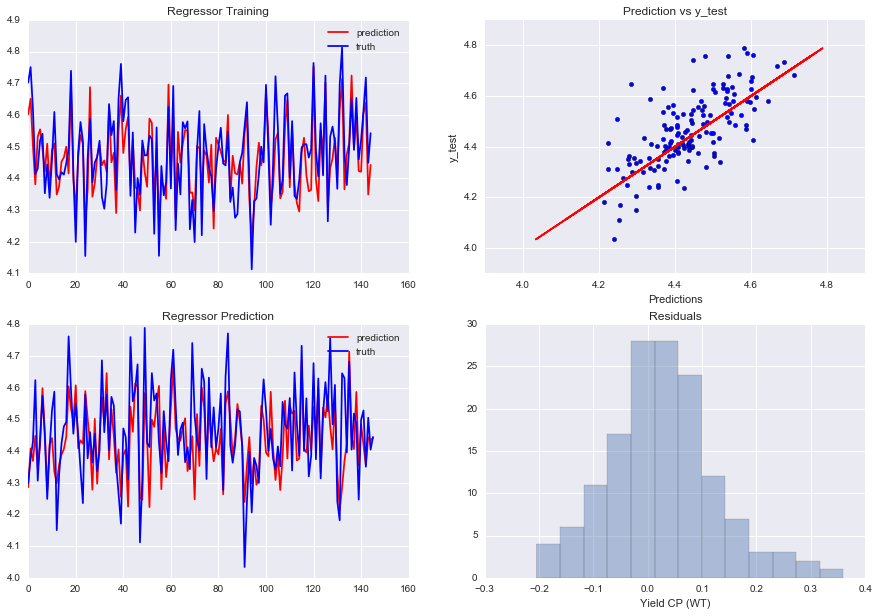

In [43]:
x_train, x_test, y_train, y_test = load_regression_data(randomState=1)

model = SVR(kernel='rbf')
model.fit(x_train,y_train)

pred = model.predict(x_test)
residuals = y_test - pred

regression_charts(model, x_train, x_test, y_train, y_test, residuals)

print 'Mean Squared Error:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,pred)
print 'Mean Absolute Error %:', sum(abs((y_test-pred) / y_test) / len(y_test))*100

# Classification
With manually selected features.

Let's try classification. The target also has a complementary column with the following values.

In [44]:
# This is how my categorical target looks like
Counter(processed_df2[processed_df2['Year']!=2014]['15and16_yield_label'])

Counter({'above 1': 51, 'above mean': 90, 'below 1': 39, 'below mean': 111})

# K Nearest Neighbors

In [62]:
x_train, x_test, y_train, y_test = load_classification_data()

model = KNeighborsClassifier(n_neighbors=6, weights='distance')
model.fit(x_train,y_train)

x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

print 'Trained model report:'
print metrics.classification_report(y_train,x_train_pred)
print 'Test model report:'
print metrics.classification_report(y_test,x_test_pred)
print 'Test model accuracy:'
print metrics.accuracy_score(y_test,x_test_pred)

Trained model report:
             precision    recall  f1-score   support

    above 1       1.00      1.00      1.00        36
 above mean       1.00      1.00      1.00        67
    below 1       1.00      1.00      1.00        26
 below mean       1.00      1.00      1.00        74

avg / total       1.00      1.00      1.00       203

Test model report:
             precision    recall  f1-score   support

    above 1       0.67      0.27      0.38        15
 above mean       0.51      0.87      0.65        23
    below 1       0.57      0.31      0.40        13
 below mean       0.69      0.68      0.68        37

avg / total       0.62      0.60      0.58        88

Test model accuracy:
0.602272727273


# Random Forest

In [46]:
x_train, x_test, y_train, y_test = load_classification_data()

model = RandomForestClassifier(n_estimators=48, 
                               max_depth=6,
                               random_state=3, 
                               class_weight='balanced_subsample')
model.fit(x_train,y_train)

x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

print 'Trained model accuracy:'
print metrics.classification_report(y_train,x_train_pred)
print 'Test model accuracy:'
print metrics.classification_report(y_test,x_test_pred)
print 'Test model accuracy:'
print metrics.accuracy_score(y_test,x_test_pred)

Trained model accuracy:
             precision    recall  f1-score   support

    above 1       1.00      0.94      0.97        36
 above mean       0.87      0.88      0.87        67
    below 1       0.92      0.88      0.90        26
 below mean       0.87      0.89      0.88        74

avg / total       0.90      0.90      0.90       203

Test model accuracy:
             precision    recall  f1-score   support

    above 1       0.57      0.53      0.55        15
 above mean       0.48      0.61      0.54        23
    below 1       0.53      0.69      0.60        13
 below mean       0.75      0.57      0.65        37

avg / total       0.62      0.59      0.60        88

Test model accuracy:
0.590909090909


In [47]:
# joblib.dump(model,'models/Random_Forest/Random_Forest_Model.pkl')
print ''

# Logistic Regression

In [48]:
x_train, x_test, y_train, y_test = load_classification_data(1)

model = LogisticRegression(fit_intercept=False, class_weight={'above 1':1,'above mean':1,'below 1':1,'below mean':1}, 
                           solver='lbfgs', multi_class='multinomial')
model.fit(x_train,y_train)

x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

print 'Trained model accuracy:'
print metrics.classification_report(y_train,x_train_pred)
print 'Test model accuracy:'
print metrics.classification_report(y_test,x_test_pred)
print 'Test model accuracy:'
print metrics.accuracy_score(y_test,x_test_pred)

Trained model accuracy:
             precision    recall  f1-score   support

    above 1       0.76      0.53      0.62        36
 above mean       0.61      0.60      0.60        67
    below 1       0.76      0.50      0.60        26
 below mean       0.61      0.78      0.69        74

avg / total       0.66      0.64      0.64       203

Test model accuracy:
             precision    recall  f1-score   support

    above 1       0.50      0.40      0.44        15
 above mean       0.44      0.48      0.46        23
    below 1       0.55      0.46      0.50        13
 below mean       0.65      0.70      0.68        37

avg / total       0.55      0.56      0.55        88

Test model accuracy:
0.556818181818


# Naive Bayes

In [49]:
x_train, x_test, y_train, y_test = load_classification_data(1)

model = GaussianNB()
model.fit(x_train,y_train)

x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

print 'Trained model accuracy:'
print metrics.classification_report(y_train,x_train_pred)
print 'Test model accuracy:'
print metrics.classification_report(y_test,x_test_pred)
print 'Test model accuracy:'
print metrics.accuracy_score(y_test,x_test_pred)

Trained model accuracy:
             precision    recall  f1-score   support

    above 1       0.68      0.36      0.47        36
 above mean       0.71      0.22      0.34        67
    below 1       0.16      0.96      0.27        26
 below mean       0.83      0.07      0.13        74

avg / total       0.68      0.29      0.28       203

Test model accuracy:
             precision    recall  f1-score   support

    above 1       0.57      0.27      0.36        15
 above mean       0.50      0.22      0.30        23
    below 1       0.19      1.00      0.33        13
 below mean       0.75      0.08      0.15        37

avg / total       0.57      0.28      0.25        88

Test model accuracy:
0.284090909091


# PCA with K-Fold Cross Validation
Let's try to use PCA to select the features for us with dimenionality reduction. And instead of using train-test-split to evaluate our models, let's use K-Fold Cross Validation.

In [50]:
# Taking out string features
feature_cols = [
#                 'Bag/Bottle',
                'PCA (%)',
                'PPT G (kg)',
                'CPP (kg)',
#               'g PPT G/kg CPP',
                'Total Protein (g/dL)',
                'CUNO Filt (kg)',
                'VP (L)',
                'Diluted CPP (kg)',
                'Dilution (kg)',
                'CPP IgG before Fr1',
                'Cuno IgG FP6',
                'Diluted % Efficiency',
                'CPP (L)',
                'G Conv (g IgG/Kg PPT G)',
                'Yield CP (WT)',
#               'Yield_Label',
#               'Yield_Label_2',
                'Yield VP (WT)',
                'I - Final pH',
                'I - Aging',
                'II+III After Alc pH',
                'II+III After Alc Titer',
                'II+III - Final pH',
                'II+III - Aging',
                'II+III Paste Wt',
                'Buffer 1 Amt',
                'Buffer 1 Percentage',
                'Extraction Ratio',
                'Extract - Final pH',
                'Extract - Aging',
                'G - Init pH',
                'G - titer',
                'G - Final pH',
                'G - Aging',
                'TD_CT',
                'FrI_PPT_CT',
                'FrII_PPT_CT',
                'V13_Sep_CT',
                'Ext_PPT_CT',
#               'G_PPT_CT',
                'bag_or_bottle_label_Bags',
                'bag_or_bottle_label_Bags/NMF',
                'bag_or_bottle_label_Bottle',
                'DilutedCPPvsCUNOFilt',
#               'DilutedCPPvsCUNOFilt_-1',
                'DilutedCPPvsCUNOFilt_0',
                'DilutedCPPvsCUNOFilt_1'
                ]
print len(feature_cols)

42


## Selecting Number of PCA Components

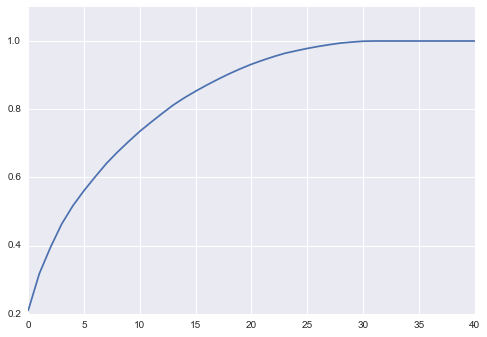

In [51]:
variance_ratio_sum = []
for i in range(1,42):
    pca = decomposition.PCA(n_components=i)
    pca.fit(rescaled_df[feature_cols])
    variance_ratio_sum.append(sum(pca.explained_variance_ratio_))
plt.plot(variance_ratio_sum)

Hard to say how many components I should pick since there's no clear plateau. Let's use a simple Linear Regression with CV to see if I get any plateaus for its mean absolute error.

Mean Absolute Error for PCA 8 components: 0.0457976081989


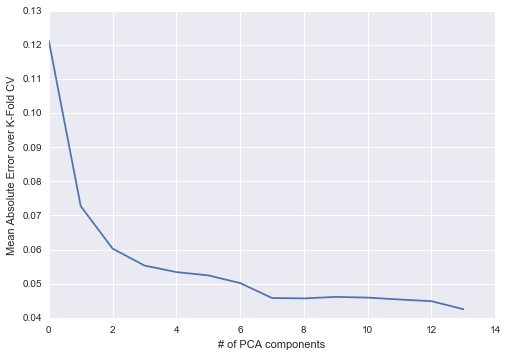

In [52]:
kf = KFold(len(rescaled_df[feature_cols]),n_folds=4)
pca_results = []

model = LinearRegression(fit_intercept=True)

for i in range(1,15): # Iterate through a range of PCAs
    mae_results = []
    for train_index,test_index in kf: # Iterate through k-folds per number of PCA components
        x_train = rescaled_df.iloc[train_index][feature_cols]
        y_train = rescaled_df.iloc[train_index]['Yield CP (WT)']
        x_test = rescaled_df.iloc[test_index][feature_cols]
        y_test = rescaled_df.iloc[test_index]['Yield CP (WT)']    

        pca = decomposition.PCA(n_components=i)
        pca.fit(x_train)
        x_train_pca = pca.transform(x_train)
        x_test_pca = pca.transform(x_test)

        model.fit(x_train_pca,y_train)
        pred = model.predict(x_test_pca)

        mae_results.append(metrics.mean_absolute_error(y_test,pred))
    pca_results.append(np.mean(mae_results))

plt.plot(pca_results)
plt.xlabel('# of PCA components')
plt.ylabel('Mean Absolute Error over K-Fold CV')

print 'Mean Absolute Error for PCA 8 components:',pca_results[7]

Seems like the sweet spot is around 8 components using Linear Regression as a sample model.

## Regression with PCA Features

### Linear Regression with PCA Features

CV mean absolute error mean: 0.0457976081989
Mean Squared Error of last CV fold: 0.0020997308934
Mean Absolute Error of last CV fold: 0.0350161641064
Mean Absolute Error % of last CV fold: 0.783120980223


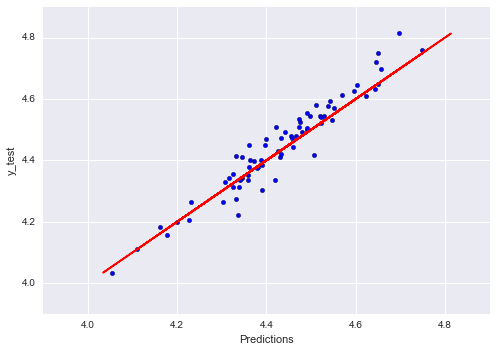

In [74]:
# Let's do K-Fold CV the long way without GridSearch once
kf = KFold(len(rescaled_df[feature_cols]),n_folds=4)
model = LinearRegression(fit_intercept=True)
mae_results = []

for train_index,test_index in kf:
    x_train = rescaled_df.iloc[train_index][feature_cols]
    y_train = rescaled_df.iloc[train_index]['Yield CP (WT)']
    x_test = rescaled_df.iloc[test_index][feature_cols]
    y_test = rescaled_df.iloc[test_index]['Yield CP (WT)']    

    pca = decomposition.PCA(n_components=8)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    model.fit(x_train_pca,y_train)
    pred = model.predict(x_test_pca)

    mae_results.append(metrics.mean_absolute_error(y_test,pred))

print 'CV mean absolute error mean:',np.mean(mae_results)
    
plt.scatter(pred,y_test)
plt.plot(y_test,y_test,'r')
plt.xlabel('Predictions')
plt.ylabel('y_test')
print 'Mean Squared Error of last CV fold:',metrics.mean_squared_error(y_test,pred)
print 'Mean Absolute Error of last CV fold:',metrics.mean_absolute_error(y_test,pred)
print 'Mean Absolute Error % of last CV fold:', sum(abs((y_test-pred) / y_test) / len(y_test))*100

Grid Searching...
Done in 0.154 seconds
Best parameters: {'LR_model__normalize': False, 'LR_model__fit_intercept': True}
Best estimator CV mean absolute error: 0.0458346578349
Model final MAE score: 0.0469328657214


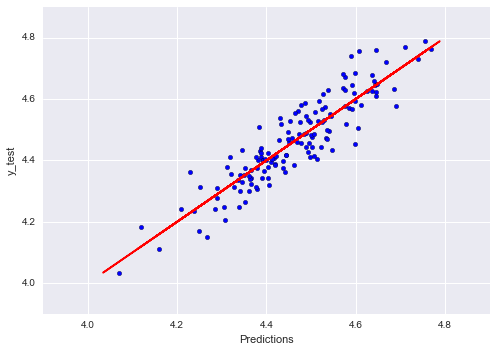

In [73]:
# This time using gridsearch and pipeline to get the best estimator
kf = KFold(len(rescaled_df),n_folds=4)
pca = decomposition.PCA(n_components=8)
model = LinearRegression()

pipe = Pipeline(steps= [('pca',pca),('LR_model',model)])

params = {'LR_model__fit_intercept':[True,False],
          'LR_model__normalize':[True,False]}
gscv = GridSearchCV(estimator=pipe, param_grid=params, scoring='mean_absolute_error', cv= kf)
startTime = timeit.default_timer()
print 'Grid Searching...'
gscv.fit(rescaled_df[feature_cols],rescaled_df['Yield CP (WT)'])
print 'Done in {} seconds'.format(round(timeit.default_timer() - startTime,3))

print 'Best parameters:',gscv.best_params_
print 'Best estimator CV mean absolute error:',-gscv.best_score_

# GridSearch trains the best_estimator with the complete dataset, I don't want that.
# That's why I'm training the best_estimator with half of my data, just to do one final check.
x_train, x_test, y_train, y_test = train_test_split(rescaled_df[feature_cols],
                                                    rescaled_df['Yield CP (WT)'],
                                                    test_size=0.5,
                                                    random_state=1)
best_model = gscv.best_estimator_
best_model.fit(x_train,y_train)
pred = best_model.predict(x_test)

plt.figure()
plt.scatter(pred,y_test)
plt.xlabel('Predictions')
plt.ylabel('y_test')
plt.plot(y_test,y_test,'r')

print 'Model final MAE score:',metrics.mean_absolute_error(y_test,pred)

### Random Forest with PCA Features

Grid Searching...
Done in 2.65 seconds
Best parameters: {'RF_model__n_estimators': 20, 'RF_model__max_depth': 6}
Best estimator CV mean absolute error: 0.060232246626
Model final MAE score: 0.0582110176339


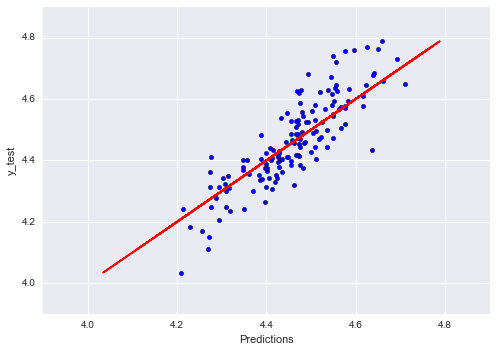

In [63]:
kf = KFold(len(rescaled_df[feature_cols]),n_folds=4)
pca = decomposition.PCA(n_components=8)
model = RandomForestRegressor(random_state=1)


pipe = Pipeline(steps=[('pca',pca),('RF_model',model)])

params = {'RF_model__n_estimators':[20,25,30],
          'RF_model__max_depth':[3,4,5,6]}

gscv = GridSearchCV(pipe,param_grid=params,cv=kf,scoring='mean_absolute_error')
tempTime = timeit.default_timer()
print 'Grid Searching...'
gscv.fit(rescaled_df[feature_cols],rescaled_df['Yield CP (WT)'])
print 'Done in {} seconds'.format(round(timeit.default_timer() - tempTime,2))

print 'Best parameters:',gscv.best_params_
print 'Best estimator CV mean absolute error:',-gscv.best_score_

# GridSearch trains the best_estimator with the complete dataset, I don't want that.
# That's why I'm training the best_estimator with half of my data, just to do one final check.
x_train, x_test, y_train, y_test = train_test_split(rescaled_df[feature_cols],
                                                    rescaled_df['Yield CP (WT)'],
                                                    test_size=0.5,
                                                    random_state=1)
best_model = gscv.best_estimator_
best_model.fit(x_train,y_train)
pred = best_model.predict(x_test)

plt.figure()
plt.scatter(pred,y_test)
plt.xlabel('Predictions')
plt.ylabel('y_test')
plt.plot(y_test,y_test,'r')

print 'Model final MAE score:',metrics.mean_absolute_error(y_test,pred)

### Support Vector Regression with PCA Features

Grid Searching...
Done in 113.62 seconds
Best parameters: {'SVR_model__kernel': 'linear', 'SVR_model__C': 100.0}
Best estimator CV mean absolute error: 0.0489867708404
Model final MAE score: 0.053543632057


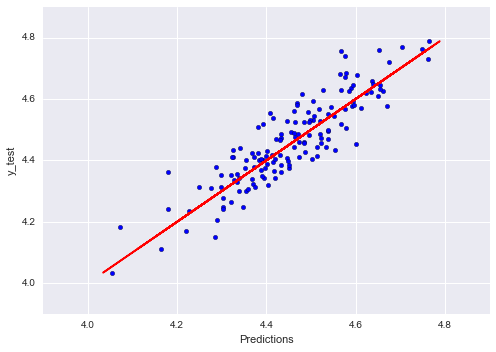

In [56]:
kf = KFold(len(rescaled_df[feature_cols]),n_folds=4)
pca = decomposition.PCA(n_components=8)
model = SVR()

pipe = Pipeline(steps=[('pca',pca),('SVR_model',model)])

params = {'SVR_model__kernel':['rbf','linear','poly'],
          'SVR_model__C':[1e2,1e3,1e4]}

gscv = GridSearchCV(pipe,param_grid=params,cv=kf,scoring='mean_absolute_error')
tempTime = timeit.default_timer()
print 'Grid Searching...'
gscv.fit(rescaled_df[feature_cols],rescaled_df['Yield CP (WT)'])
print 'Done in {} seconds'.format(round(timeit.default_timer() - tempTime,2))

print 'Best parameters:',gscv.best_params_
print 'Best estimator CV mean absolute error:',-gscv.best_score_

# GridSearch trains the best_estimator with the complete dataset, I don't want that.
# That's why I'm training the best_estimator with half of my data, just to do one final check.
x_train, x_test, y_train, y_test = train_test_split(rescaled_df[feature_cols],
                                                    rescaled_df['Yield CP (WT)'],
                                                    test_size=0.5,
                                                    random_state=1)
best_model = gscv.best_estimator_
best_model.fit(x_train,y_train)
pred = best_model.predict(x_test)

plt.figure()
plt.scatter(pred,y_test)
plt.xlabel('Predictions')
plt.ylabel('y_test')
plt.plot(y_test,y_test,'r')
print 'Model final MAE score:',metrics.mean_absolute_error(y_test,pred)

## Classification with PCA Features

In [57]:
Counter(rescaled_df['15and16_yield_label'])

Counter({'above 1': 51, 'above mean': 90, 'below 1': 39, 'below mean': 111})

### K-Nearest-Neighbor Classification with PCA Features

In [58]:
# NOTE: Classification problems should use Stratefied K-Fold
# Using n_fold = 3 because for one of the classes, we don't have that many counts
kf = StratifiedKFold(rescaled_df['15and16_yield_label'],n_folds=3)
pca = decomposition.PCA(n_components=8)
model = KNeighborsClassifier()

pipe = Pipeline(steps=[('pca',pca),('KNN_model',model)])

params = {'KNN_model__weights':['uniform','distance'],
          'KNN_model__n_neighbors':[3,4,5,6]}

gscv = GridSearchCV(pipe,param_grid=params,cv=kf,scoring='accuracy')
tempTime = timeit.default_timer()
print 'Grid Searching...'
gscv.fit(rescaled_df[feature_cols],rescaled_df['15and16_yield_label'])
print 'Done in {} seconds'.format(round(timeit.default_timer() - tempTime,2))

print 'Best parameters:',gscv.best_params_
print 'Best estimator score:',gscv.best_score_

# GridSearch trains the best_estimator with the complete dataset, I don't want that.
# That's why I'm training the best_estimator with half of my data, just to do one final check.
x_train, x_test, y_train, y_test = train_test_split(rescaled_df[feature_cols],
                                                    rescaled_df['15and16_yield_label'],
                                                    test_size=0.5,
                                                    stratify = rescaled_df['15and16_yield_label'],
                                                    random_state=1)

best_model = gscv.best_estimator_
best_model.fit(x_train,y_train)
pred = best_model.predict(x_test)

print 'Final Model Classification Report:'
print metrics.classification_report(y_test,pred)

Grid Searching...
Done in 0.17 seconds
Best parameters: {'KNN_model__weights': 'uniform', 'KNN_model__n_neighbors': 3}
Best estimator score: 0.601374570447
Final Model Classification Report:
             precision    recall  f1-score   support

    above 1       0.50      0.31      0.38        26
 above mean       0.44      0.62      0.52        45
    below 1       0.75      0.30      0.43        20
 below mean       0.57      0.61      0.59        56

avg / total       0.54      0.52      0.51       147



### Random Forest Classification with PCA Features

In [59]:
kf = StratifiedKFold(rescaled_df['15and16_yield_label'],n_folds=3)
pca = decomposition.PCA(n_components=8)
model = RandomForestClassifier()

pipe = Pipeline(steps=[('pca',pca),('RF_model',model)])

params = {'RF_model__n_estimators':[15,20,25],
          'RF_model__max_depth':[3,4,5,6]}

gscv = GridSearchCV(pipe,param_grid=params,cv=kf,scoring='accuracy')
tempTime = timeit.default_timer()
print 'Grid Searching...'
gscv.fit(rescaled_df[feature_cols],rescaled_df['15and16_yield_label'])
print 'Done in {} seconds'.format(round(timeit.default_timer() - tempTime,2))

print 'Best parameters:',gscv.best_params_
print 'Best estimator score:',gscv.best_score_

# GridSearch trains the best_estimator with the complete dataset, I don't want that.
# That's why I'm training the best_estimator with half of my data, just to do one final check.
x_train, x_test, y_train, y_test = train_test_split(rescaled_df[feature_cols],
                                                    rescaled_df['15and16_yield_label'],
                                                    test_size=0.5,
                                                    stratify = rescaled_df['15and16_yield_label'],
                                                    random_state=1)

best_model = gscv.best_estimator_
best_model.fit(x_train,y_train)
pred = best_model.predict(x_test)

print 'Final Model Classification Report:'
print metrics.classification_report(y_test,pred)

Grid Searching...
Done in 1.75 seconds
Best parameters: {'RF_model__n_estimators': 25, 'RF_model__max_depth': 6}
Best estimator score: 0.59793814433
Final Model Classification Report:
             precision    recall  f1-score   support

    above 1       0.91      0.38      0.54        26
 above mean       0.43      0.58      0.49        45
    below 1       0.80      0.20      0.32        20
 below mean       0.50      0.62      0.56        56

avg / total       0.59      0.51      0.50       147



### Logistic Regression Classification with PCA Features

In [60]:
kf = StratifiedKFold(rescaled_df['15and16_yield_label'],n_folds=3)
pca = decomposition.PCA(n_components=8)
model = LogisticRegression(random_state=1)

pipe = Pipeline(steps=[('pca',pca),('LR_model',model)])

params = {'LR_model__fit_intercept':[True,False],
          'LR_model__C':[10,1e3,1e4,1e5],
          'LR_model__class_weight':[None,'balanced']}

gscv = GridSearchCV(pipe,param_grid=params,cv=kf,scoring='accuracy')
tempTime = timeit.default_timer()
print 'Grid Searching...'
gscv.fit(rescaled_df[feature_cols],rescaled_df['15and16_yield_label'])
print 'Done in {} seconds'.format(round(timeit.default_timer() - tempTime,2))

print 'Best parameters:',gscv.best_params_
print 'Best estimator score:',gscv.best_score_

# GridSearch trains the best_estimator with the complete dataset, I don't want that.
# That's why I'm training the best_estimator with half of my data, just to do one final check.
x_train, x_test, y_train, y_test = train_test_split(rescaled_df[feature_cols],
                                                    rescaled_df['15and16_yield_label'],
                                                    test_size=0.5,
                                                    stratify = rescaled_df['15and16_yield_label'],
                                                    random_state=1)

best_model = gscv.best_estimator_
best_model.fit(x_train,y_train)
pred = best_model.predict(x_test)

print 'Final Model Classification Report:'
print metrics.classification_report(y_test,pred)

Grid Searching...
Done in 0.45 seconds
Best parameters: {'LR_model__C': 1000.0, 'LR_model__fit_intercept': True, 'LR_model__class_weight': None}
Best estimator score: 0.670103092784
Final Model Classification Report:
             precision    recall  f1-score   support

    above 1       0.84      0.62      0.71        26
 above mean       0.50      0.56      0.53        45
    below 1       0.73      0.40      0.52        20
 below mean       0.55      0.66      0.60        56

avg / total       0.61      0.59      0.59       147



### Naive Bayes Classification with PCA Features

In [61]:
# No need for parameter grid for Naive Bayes model
# So there's no need to do grid search CV, just need to do a normal CV
kf = StratifiedKFold(rescaled_df['15and16_yield_label'],n_folds=3)
pca = decomposition.PCA(n_components=8)

model = GaussianNB()

pipe = Pipeline(steps=[('pca',pca),('NB_model',model)])

cvScores = cross_val_score(estimator=pipe,
                           X=rescaled_df[feature_cols],
                           y=rescaled_df['15and16_yield_label'],
                           cv=kf,
                           scoring='accuracy')

print 'Mean CV accuracy score:',np.mean(cvScores)

# CV doesn't fit a final estimator, fitting one here
x_train, x_test, y_train, y_test = train_test_split(rescaled_df[feature_cols],
                                                    rescaled_df['15and16_yield_label'],
                                                    test_size=0.5,
                                                    stratify = rescaled_df['15and16_yield_label'],
                                                    random_state=1)

model.fit(x_train,y_train)
pred = model.predict(x_test)

print 'Final Model Classification Report:'
print metrics.classification_report(y_test,pred)#

Mean CV accuracy score: 0.560137457045
Final Model Classification Report:
             precision    recall  f1-score   support

    above 1       0.78      0.69      0.73        26
 above mean       0.68      0.76      0.72        45
    below 1       0.29      0.90      0.44        20
 below mean       0.75      0.16      0.26        56

avg / total       0.67      0.54      0.51       147



# Neural Networks

## Regression

In [82]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

In [83]:
# Loading features
features = np.array(rescaled_df[feature_cols])
target = np.array(rescaled_df[['Yield CP (WT)']])


x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 1)


pca = decomposition.PCA(n_components=8)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [84]:
model = Sequential()
model.add(Dense(input_dim = 8, output_dim = 12, activation='tanh'))
model.add(Dense(input_dim = 12, output_dim = 12, activation='tanh'))
# model.add(Dense(input_dim = 12, output_dim = 12, activation='tanh'))
# model.add(Dense(input_dim = 12, output_dim = 12, activation='tanh'))
# model.add(Dense(input_dim = 12, output_dim = 12, activation='tanh'))
model.add(Dense(input_dim = 12, output_dim = 1, activation='linear'))

model.compile(optimizer=SGD(lr=0.0004), loss='mae')

print "Training..."
startTime = timeit.default_timer()
model_history = model.fit(x_train_pca,y_train,nb_epoch=40000,verbose=False)
print "Done. Training Time:", timeit.default_timer() - startTime

Training...
Done. Training Time: 114.367623027


0.018123720832374117

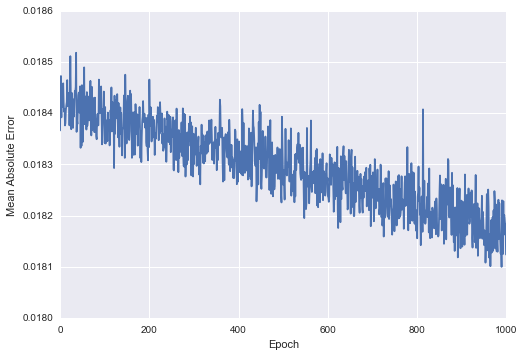

In [85]:
# Plotting the neural network training loss history
plt.plot(model_history.history['loss'][-1000:])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
model_history.history['loss'][-1]

Mean Squared Error: 0.00642407833127
Mean Absolute Error: 0.0612887123297


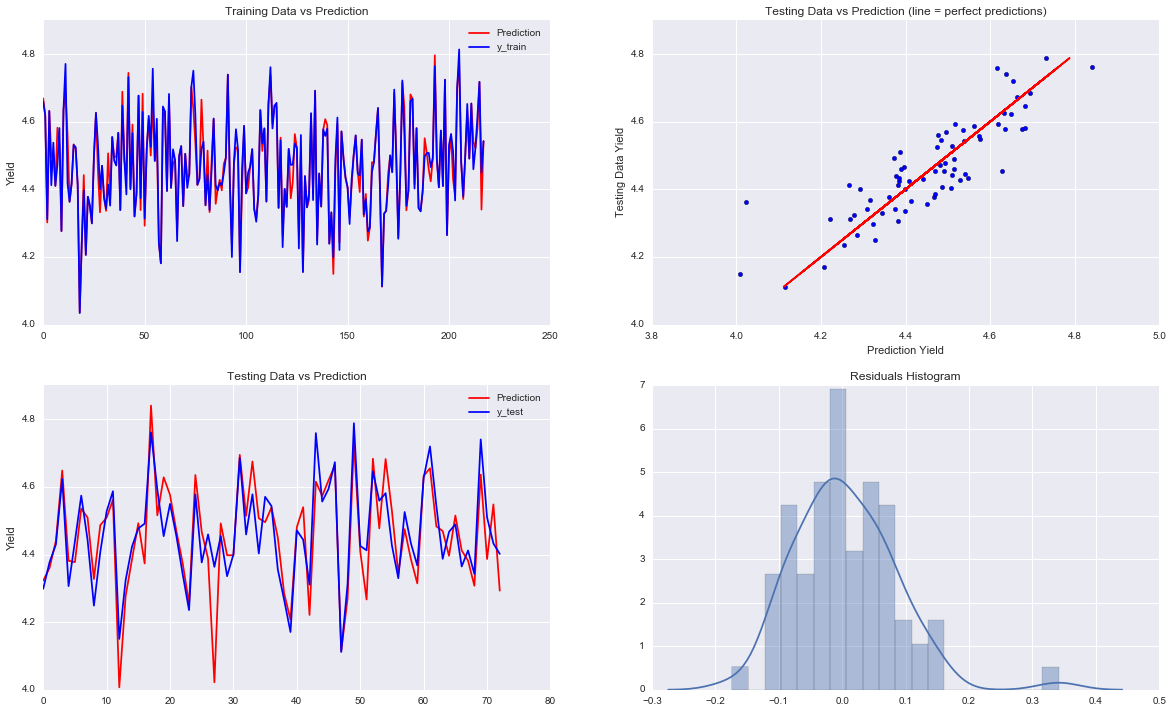

In [86]:
train_pred = model.predict(x_train_pca)

test_pred = model.predict(x_test_pca)
residuals = y_test-test_pred


fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,12))

# Charting
axes[0,0].plot(range(len(train_pred)),train_pred,'r',label='Prediction')
axes[0,0].plot(range(len(y_train)),y_train,'b',label='y_train')
axes[0,0].set_title('Training Data vs Prediction')
axes[0,0].set_ylabel('Yield')
axes[0,0].legend()

axes[1,0].plot(range(len(test_pred)),test_pred,'r',label='Prediction')
axes[1,0].plot(range(len(y_test)),y_test,'b',label='y_test')
axes[1,0].set_title('Testing Data vs Prediction')
axes[1,0].set_ylabel('Yield')
axes[1,0].legend()

axes[0,1].scatter(test_pred,y_test)
axes[0,1].plot(y_test,y_test,'r')
axes[0,1].set_xlabel('Prediction Yield')
axes[0,1].set_ylabel('Testing Data Yield')
axes[0,1].set_title('Testing Data vs Prediction (line = perfect predictions)')

sns.distplot(residuals,ax=axes[1,1], bins=20)
plt.title('Residuals Histogram')

print 'Mean Squared Error:',metrics.mean_squared_error(y_test,test_pred)
print 'Mean Absolute Error:',metrics.mean_absolute_error(y_test,test_pred)

In [87]:
# model.save('models/Neural_Network_Regression/neural_network_model.h5')

## Classification

In [88]:
# Loading features
features = np.array(rescaled_df[feature_cols])

convertDict = {'below 1':0,'below mean':1,'above mean':2,'above 1':3}
target = rescaled_df['15and16_yield_label'].apply(lambda x: convertDict[x])

# Keras want the target to be in a form of (# of observations, # of classes). One-hot encoding.
target = np.array(pd.get_dummies(target))


x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 1)


pca = decomposition.PCA(n_components=8)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [89]:
model = Sequential()
model.add(Dense(input_dim=8,output_dim=12,activation='relu'))
model.add(Dense(output_dim=12,activation='relu'))
model.add(Dense(output_dim=12,activation='relu'))
# model.add(Dense(output_dim=12,activation='relu'))
# model.add(Dense(output_dim=12,activation='relu'))
model.add(Dense(output_dim=4,activation='softmax'))

RMS = RMSprop(lr=0.0002)

model.compile(loss='categorical_crossentropy', optimizer=RMS)

print "Training..."
startTime = timeit.default_timer()
model_history = model.fit(x_train_pca,y_train,nb_epoch=20000,verbose=False)
print "Done. Training Time:", timeit.default_timer() - startTime

Training...
Done. Training Time: 57.2702585583


1.19209303762e-07


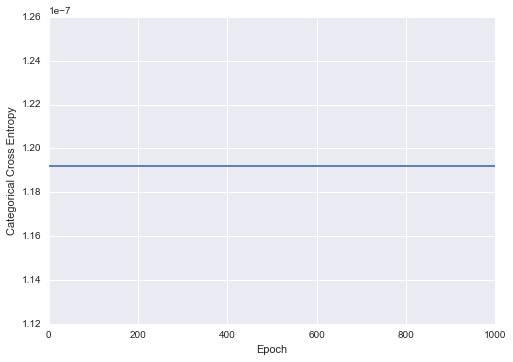

In [90]:
print model_history.history['loss'][-1]
plt.plot(model_history.history['loss'][-1000:])
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')

In [91]:
test_pred = model.predict_classes(x_test_pca, verbose=False)

# Collapsing the categorical columns back into one column
# 'below 1':0,'below mean':1,'above mean':2,'above 1':3
y_testList = []
for i in y_test:
    if i[0]:
        y_testList.append(0)
    elif i[1]:
        y_testList.append(1)
    elif i[2]:
        y_testList.append(2)
    elif i[3]:
        y_testList.append(3)

print 'Confusion Matrix Scores:'
print metrics.classification_report(y_testList,test_pred)
print ''
print 'Accuracy Score:'
print metrics.accuracy_score(y_testList,test_pred)

Confusion Matrix Scores:
             precision    recall  f1-score   support

          0       0.78      0.64      0.70        11
          1       0.79      0.72      0.75        32
          2       0.65      0.65      0.65        20
          3       0.67      1.00      0.80        10

avg / total       0.73      0.73      0.72        73


Accuracy Score:
0.72602739726


In [92]:
# model.save('models/Neural_Network_Classification/neural_network_classification.h5')